# Prototype of the Inclinet model
## Classification

Most of this work has been fully explained with details [here](https://github.com/ekourkchi/incNET-data/blob/master/incNET_CNN_Colabs/Prototype_RGB64x64_VGGregression.ipynb), where we investigated a regression CNN. We don't repeat the similar findings here. 

To generate a basic prototype, we reduced the size of 512x512 images to 64x64.
Only RGB images are used in this model, and the semi-major axes of galaxies are alligned horizantally to the best of our knowledge. 


In [ ]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

# from google.colab import drive
# drive.mount('/content/drive')

## Importing Packages

In [ ]:
data = np.load('/content/drive/My Drive/Colab Notebooks/data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

51


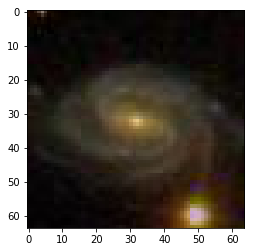

In [ ]:
i = 750
print labels_[1][i]
plt.imshow(images_[i])

(array([ 792., 2912., 3172., 2532., 3868., 3824., 6168., 5340., 6384.,
        9228.]),
 array([45. , 49.5, 54. , 58.5, 63. , 67.5, 72. , 76.5, 81. , 85.5, 90. ]),
 <a list of 10 Patch objects>)

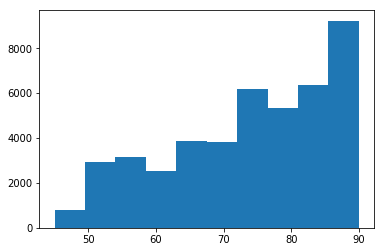

In [ ]:
plt.hist(labels_[1][labels_[1]>=45])

In [ ]:
def esn_shuffle(array, seed=0):
        random.seed(seed)
        random.shuffle(array)
        return array

In [ ]:
n = len(labels_c)

indices = np.arange(n)
indices = esn_shuffle(indices, seed=0)


images_cc = images_c[indices]
labels_cc = labels_c[indices]
pgcIDs_cc = pgcIDs_c[indices]

#################

indices = np.arange(1000)
images_test  = images_cc[indices]
labels_test  = labels_cc[indices]
pgcIDs_test  = pgcIDs_cc[indices]

################# 

indices = np.arange(1000, n)
images_train = images_cc[indices]
labels_train = labels_cc[indices]
pgcIDs_train = pgcIDs_cc[indices]


ibx = np.logical_not(np.isin(pgcIDs_train, pgcIDs_test))
images_train = images_train[ibx]
labels_train = labels_train[ibx]
pgcIDs_train = pgcIDs_train[ibx]

#################
# Taking only unique galxies in the test set
# This is the brute-force approach.
# I need to make this better in the future

unique_IDs = []
unique_inx = []

for i, id in enumerate(pgcIDs_test):
    if not id in unique_IDs:
        unique_IDs.append(id)
        unique_inx.append(i)
        
        
images_test  = images_test[unique_inx]
labels_test  = labels_test[unique_inx]
pgcIDs_test  = pgcIDs_test[unique_inx]

In [ ]:
print images_train.shape , labels_train.shape
print images_test.shape , labels_test.shape


(40384, 64, 64, 3) (40384,)
(959, 64, 64, 3) (959,)


(array([ 13.,  62.,  65.,  56.,  87.,  84., 124., 120., 144., 204.]),
 array([45. , 49.5, 54. , 58.5, 63. , 67.5, 72. , 76.5, 81. , 85.5, 90. ]),
 <a list of 1 Patch objects>)

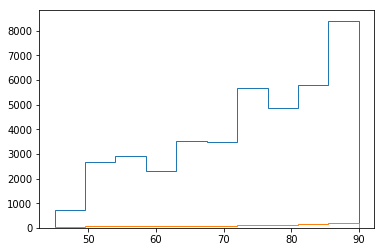

In [ ]:
plt.hist(labels_train, histtype='step', label='train')
plt.hist(labels_test, histtype='step', label='test')

Mapping inclinations to classes labelled with integer numbers ranging from 0 to 45.

In [ ]:
labels_train  = labels_train - 45
labels_test   = labels_test - 45
images_test   = images_test / 255.
images_train  = images_train / 255.

The last layer of network uses *Softmax* as the activation layer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(64, 64, 1), n_classes= 46):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 64x64 images with 1 channel -> (64, 64, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [ ]:
vgg_model = vgg6()
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
n_epochs = 100
vgg_model.summary()
vgg_model_history = vgg_model.fit(Train2D_seed0['X']/255., Train2D_seed0['y']-45, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_split=0.2,
                                  shuffle=True)


Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 26, 26, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 26, 26, 32)        128    

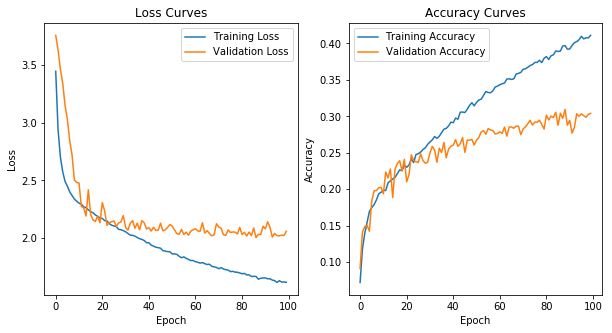

In [ ]:
plot_model_history(vgg_model.history)

In [ ]:
# predictions
inc_p = np.argmax(vgg_model.predict(Test2D_seed0['X']/255.), axis=1)+45
# measurements
inc_m = Test2D_seed0['y']

N = Test2D_seed0['y'].shape[0]
inc_p = inc_p.reshape(N)

The prediction-measurement bis seems to be at minimum here (compared to our regression model). However other realization of this model (starting over with other random initialization) generate slight biases which are not that significant.

Raw RMS: 3.60 deg
Adjusted RMS: 3.61 deg


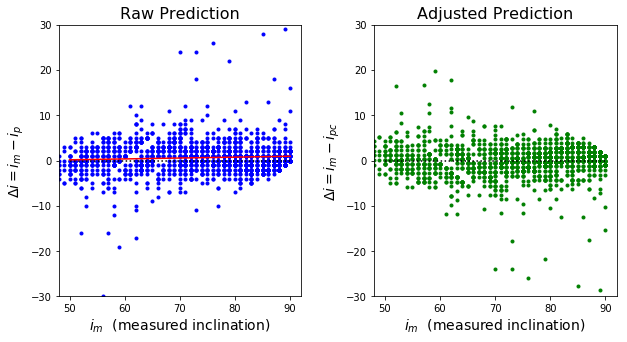

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30 ,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print("Raw RMS: %.2f deg"%np.sqrt(np.mean((d)**2)))

# adjusting the predicted inclinations using the linear model of the bias
inc_pc = (inc_p+b)/(1.-m)
d_ = inc_pc-inc_m

ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print("Adjusted RMS: %.2f deg"%np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

('MAE: 2.227', ' RMSE: 3.601')


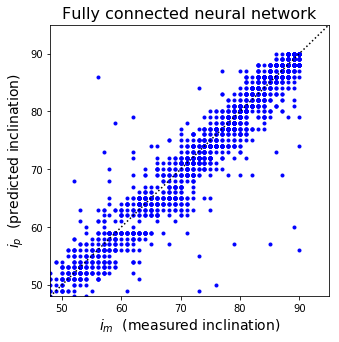

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
ax.plot(inc_m, inc_p, '.', color='b')
ax.plot([48,95],[48,95], 'k:')
ax.set_xlim(48,95)
ax.set_ylim(48,95)
ax.set_title('Fully connected neural network', fontsize=16)
ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

metrics(inc_p, inc_m)

### Visualizing galaxy images

Here, we show the first 30 galaxy images in the test sample. In each panel, cyan label is the galaxy ID in the *Principal Galaxy  Catalog* (PGC), and green and red labels represent the measured and the raw predicted inclinations. Magenta labels are the predicted inclinations after applying the linear adjustments.

The image of each galaxy and its photoemtry details can be queried using the following URL query

`http://edd.ifa.hawaii.edu/cf4_photometry/get_sdss_cf4.php?pgc=<PGC>`
where `<PGC>` is replaced by the PGC ID of the desired galaxy. 

To determine the inclination of the galaxy in a manual interactive process using *GIZ*, you can follow this URL template
`https://edd.ifa.hawaii.edu/inclination/practice.php?pgc=<PGC>`

### Examining the outliers

Here, we try to check out the outliers and see if there is any noticeable similar feature or issues that might cause an issue for the network. We look for noise levels, significant spikes, very bright stars or anything that might have distracted the network from producing the correct answer.

White labels on the top right corner of each panel represent the panel number for better referencing in the text.


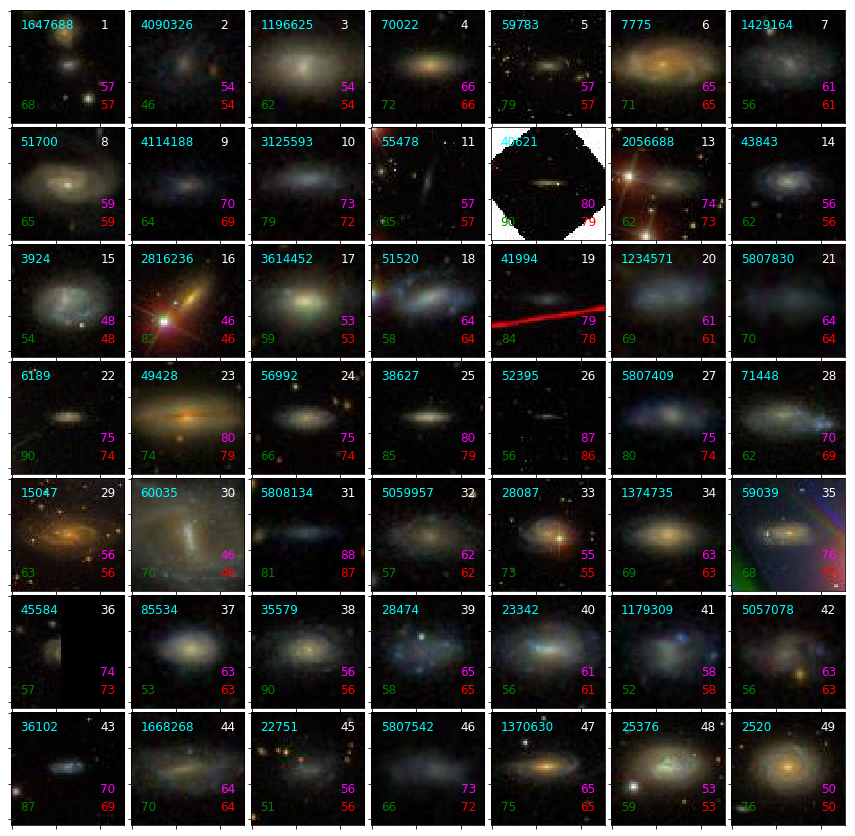

In [ ]:
n = 7
m = 7

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
ii = 1
delta = np.abs(inc_m[t]-inc_pc[t])
for i in range(n):
    for j in range(m):
        
        while t<len(inc_m) and delta < 5:
          t += 1
          delta = np.abs(inc_m[t]-inc_pc[t])

        if t<len(inc_m):
          ax = axes[i][j]
          ax.imshow(images_test[t,:,:])

          plt.setp(ax.get_xticklabels(), visible=False)
          plt.setp(ax.get_yticklabels(), visible=False)

          ax.text(5, 55, inc_m[t], color='green', fontsize=12)
          ax.text(50, 10, ii, color='white', fontsize=12); ii+=1
          ax.text(50, 55, "%.0f"%inc_p[t], color='red', fontsize=12)
          ax.text(50, 45, "%.0f"%inc_pc[t], color='magenta', fontsize=12)
          ax.text(5, 10, pgcIDs_test[t], color='cyan', fontsize=12)

          t+=1
          delta = np.abs(inc_m[t]-inc_pc[t])

plt.subplots_adjust(hspace=0.03, wspace=0.03)

## Summary

In this notebook, we looked at the problem through the lens of classification.

[In this notebook](https://github.com/ekourkchi/incNET-data/blob/master/incNET_CNN_Colabs/Prototype_RGB64x64_VGGregression.ipynb), we explore the possibility of invoking the regression techniques, and their associated loss functions. 

The root mean square of the prediction$-$measurements differences is $~3.6^o$. The similar metric is $~2.6^o$ when we compare the measured values of two groups of the human users. This means our model doesn't outperform human, and most of that poor performances is attributed to the outliers and features (like data noise, point sources, stellar spikes, poor images, etc.) without enough data coverage.

Out of our 3 different regression approaches, this classification approach is mostly similar to the one with *Tanh* activation in the last layer trained with a resampled ensemble that has uniform inclination distribution. The prediction-measurement bias is less pronounced in the classification approach, however the regression approach outperforms the classification method. The reason is that, small mistakes are treated the same way as the larger mistakes in the classification loss functions, however the regression loss functions care about how large mistakes are. 

Ultimately, this analysis recommends us to invoke the regression methodology to get more precise results. To minimize the bias, the labels of the training sample must be uniformed and *Tanh* can be leveraged for better convergence and limiting the network outputs.